In [1]:
#importing libraries
import pandas as pd
import numpy as np
import io
import requests

In [2]:
print("Getting data from S3 storage")

Getting data from S3 storage


In [3]:
#assign the data a name for easy access
data=pd.read_csv('loan_data.csv',low_memory=False)

In [4]:
#data.head(10000).to_csv("loan_data1.csv",index=False)

In [5]:
print("Loan data pre processing")

Loan data pre processing


In [6]:
#drop columns containing nans > 40%
col = data.columns
for c in col:
  if data[c].isna().sum()*100/data.shape[0] > 40:
    data.drop([c],axis=1,inplace=True)
    col = data.columns

In [7]:
print(data.shape)

(1048575, 101)


In [8]:
data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,2500,2500,2500.0,36 months,13.56,84.92,C,C1,Chef,10+ years,...,0.0,1,0,60124,16901,36500,18124,N,Cash,N
1,30000,30000,30000.0,60 months,18.94,777.23,D,D2,Postmaster,10+ years,...,0.0,1,0,372872,99468,15000,94072,N,Cash,N
2,5000,5000,5000.0,36 months,17.97,180.69,D,D1,Administrative,6 years,...,0.0,0,0,136927,11749,13800,10000,N,Cash,N
3,4000,4000,4000.0,36 months,18.94,146.51,D,D2,IT Supervisor,10+ years,...,100.0,0,0,385183,36151,5000,44984,N,Cash,N
4,30000,30000,30000.0,60 months,16.14,731.78,C,C4,Mechanic,10+ years,...,0.0,0,0,157548,29674,9300,32332,N,Cash,N


In [9]:
# splitting the data into training and test datasets
from sklearn.model_selection import train_test_split

np.random.seed(10)

train, test = train_test_split(data, test_size=0.3)

In [10]:
# Drop rows containing Nan's
train = train.dropna()
test = test.dropna()

In [11]:
un_train=train
un_test=test

In [12]:
# Separating out categorical and numerical
categorical_df = train.select_dtypes(exclude = np.number)
numerical_df = train.select_dtypes(include = np.number)

tst_categorical_df = test.select_dtypes(exclude = np.number)
tst_numerical_df = test.select_dtypes(include = np.number)

In [13]:
# Figuring out which columns has less than or equal to 20 unique values, so that we can perform onehot encoding on those columns.
onehot_df = pd.DataFrame()
for c in categorical_df.columns:
  if len(categorical_df[c].unique()) <= 20:
    onehot_df[c] = categorical_df[c]    

tst_onehot_df = pd.DataFrame()
for c in tst_categorical_df.columns:
  if len(test[c].unique()) <= 20:
    tst_onehot_df[c] = tst_categorical_df[c]

In [14]:
# Storing the other columns which have more unique values in another dataframe.
other_var = categorical_df

for c in onehot_df:
  other_var = other_var.drop([c], axis=1)


other_var_tst = tst_categorical_df

for c in tst_onehot_df:
  other_var_tst = other_var_tst.drop([c], axis=1)  

# For the variables in other_var, let us group them first, and then apply onehot encoding.  

In [15]:
# Defining a function to get the range of columns, so that it becomes easy for grouping.
def minmax(x):
    min_val = min(x)
    max_val = max(x)

    return (min_val, max_val)

In [16]:
# Converting the date columns to datetime so that we can make some time duration out of it.

date_col = ['issue_d','last_pymnt_d','earliest_cr_line','last_credit_pull_d']

for c in date_col:
   other_var[c] = pd.to_datetime(pd.Series(other_var[c]), format='%b-%y')

for c in date_col:
   other_var_tst[c] = pd.to_datetime(pd.Series(other_var_tst[c]), format='%b-%y') 

In [17]:
# Finding difference between the dates and dropping main columns

other_var['diff_issue_lastpymnt'] = other_var['last_pymnt_d'] - other_var['issue_d'] 
other_var['diff_earliestcrline_lastcrdtpull'] = other_var['last_credit_pull_d'] - other_var['earliest_cr_line']

for c in date_col:
  other_var = other_var.drop([c], axis = 1)

other_var_tst['diff_issue_lastpymnt'] = other_var_tst['last_pymnt_d'] - other_var_tst['issue_d'] 
other_var_tst['diff_earliestcrline_lastcrdtpull'] = other_var_tst['last_credit_pull_d'] - other_var_tst['earliest_cr_line']

for c in date_col:
  other_var_tst = other_var_tst.drop([c], axis = 1)  

In [18]:
# Converting time duration to numeric
other_var['diff_issue_lastpymnt'] = other_var.diff_issue_lastpymnt.apply(lambda x: x.days)
other_var['diff_earliestcrline_lastcrdtpull'] = other_var.diff_earliestcrline_lastcrdtpull.apply(lambda x: x.days)

other_var_tst['diff_issue_lastpymnt'] = other_var_tst.diff_issue_lastpymnt.apply(lambda x: x.days)
other_var_tst['diff_earliestcrline_lastcrdtpull'] = other_var_tst.diff_earliestcrline_lastcrdtpull.apply(lambda x: x.days)

In [19]:
# Dropping the zipcode column as it cannot give any info about the place as there are around 41000 zipcodes in the us and only around 900 zipcodes in the dataset.
other_var = other_var.drop(['zip_code'],axis=1)

other_var_tst = other_var_tst.drop(['zip_code'],axis=1)

In [20]:
other_var

,sub_grade,emp_title,addr_state,diff_issue_lastpymnt,diff_earliestcrline_lastcrdtpull
410465,B4,Technical Advisor,TX,337,5816
723222,G2,Operations Supervisor,OR,1067,5785
755693,C1,Director of Engineering,TX,304,12510
854924,C1,Closing coordinator,CA,151,6026
9551,A1,Custodial Supervisor,CO,62,4445
...,...,...,...,...,...
533660,D5,Payment services rep,SC,304,3378
105595,B2,Electronic Warfare Systems Techician II,NV,123,3014
617841,A5,Correctional Sergeant,CA,426,5571
443712,A3,nurse,NY,365,5205


In [21]:
# Assigning good loan as '0' and bad loan as '1'
onehot_df['loan_status'] = onehot_df['loan_status'].replace({"Current": "0", "Fully Paid": "0", "Charged Off": "1", "Late (31-120 days)":"1", "In Grace Period":"1", "Late (16-30 days)":"1", "Default":"1"})

tst_onehot_df['loan_status'] = tst_onehot_df['loan_status'].replace({"Current": "0", "Fully Paid": "0", "Charged Off": "1", "Late (31-120 days)":"1", "In Grace Period":"1", "Late (16-30 days)":"1", "Default":"1"})

In [22]:
un_onehot_df=onehot_df
un_tst_onehot_df=tst_onehot_df

In [23]:
target = train['loan_status']
tst_target = test['loan_status']

un_onehot_df = un_onehot_df.drop(['loan_status'], axis = 1)
un_tst_onehot_df = un_tst_onehot_df.drop(['loan_status'], axis = 1)

Text(0.5, 0, 'STATE')

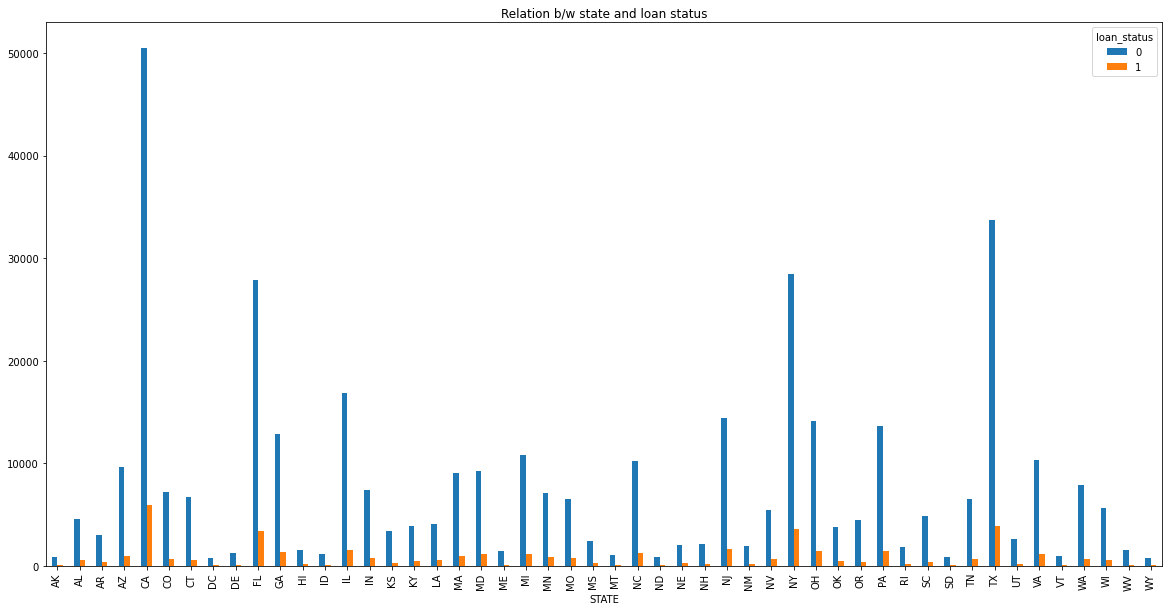

In [24]:
# Check the relation state name has with loan status, so that we get an idea whether to drop or keep that column.
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
pd.crosstab(other_var.addr_state,onehot_df.loan_status).plot(kind='bar')
plt.title('Relation b/w state and loan status')
plt.xlabel('STATE')

In [25]:
# Let us find the bad loan percentage mathematically.
l = pd.crosstab(other_var.addr_state,onehot_df.loan_status)
perc = list()
perc = 100*l['1']/(l['0']+l['1'])
print(minmax(perc))

(5.170821791320407, 12.465314834578441)


From the above figure and percentages we can observe that, state doesn't have an impact on the loan status as the ratio to good and bad loan is almost the same, so we'll go ahead and drop the column.

In [26]:
# Dropping addr_state column
other_var = other_var.drop(['addr_state'],axis=1)

other_var_tst = other_var_tst.drop(['addr_state'],axis=1)

Text(0.5, 0, 'Sub grade')

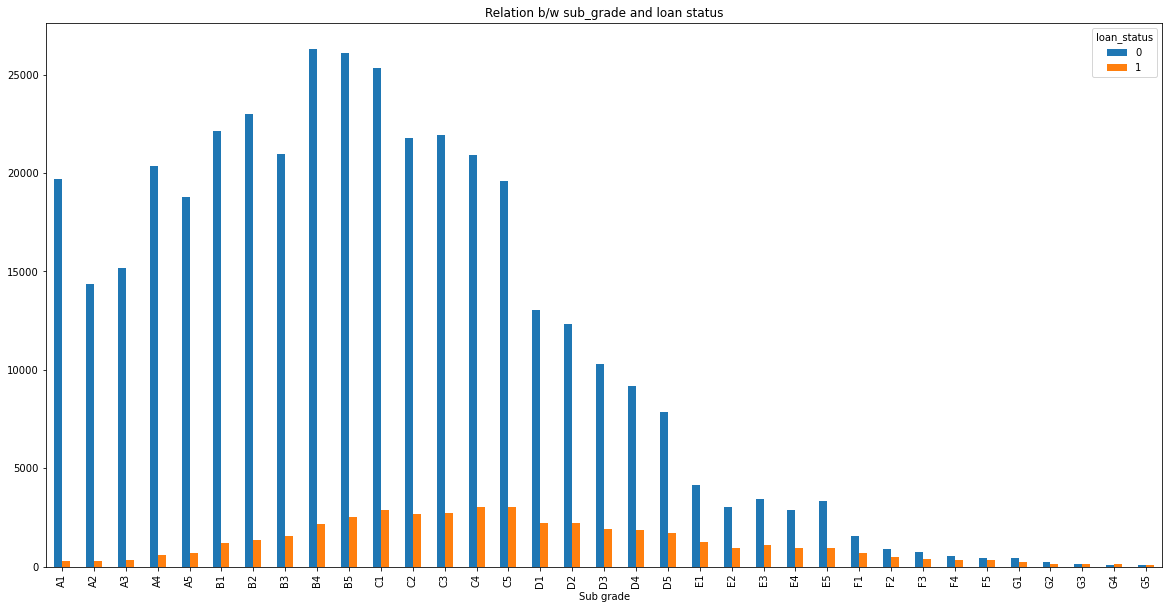

In [27]:
# Check the relation sub_grade has with loan status, so that we get an idea whether to drop or keep that column.
import matplotlib.pyplot as plt
pd.crosstab(other_var.sub_grade,onehot_df.loan_status).plot(kind='bar')
plt.title('Relation b/w sub_grade and loan status')
plt.xlabel('Sub grade')

In [28]:
# Let us find the bad loan percentage mathematically.
m = pd.crosstab(other_var.sub_grade,onehot_df.loan_status)
percent = list()
percent = 100*m['1']/(m['0']+m['1'])
print(minmax(percent))

(1.402735333901107, 52.83018867924528)


In [29]:
# Lets create a function to reduce columns in the above method.
def crosstabs(column,target):
 m = pd.crosstab(column,target)
 percent = 100*m['1']/(m['0']+m['1'])
 print(minmax(percent))

As we can see, the range of percentage for good loan to bad loan is huge. So we keep the column and try to find a way to convert it to numeric.

In [30]:
# If we observe, the ratios are in descending order. So, simple label encoding would work for this column
other_var['sub_grade']=pd.factorize( other_var['sub_grade'] )[0]

other_var_tst['sub_grade']=pd.factorize( other_var_tst['sub_grade'] )[0]

In [31]:
# dropping emp_title as it can cause disturbances in the model (Train and test datasets might not have same unique emp_title(s)).
other_var= other_var.drop(['emp_title'],axis=1)

other_var_tst = other_var_tst.drop(['emp_title'],axis=1)

In [32]:
#let us perform onehot encoding on onehot_df

In [33]:
onehot_dfcol = onehot_df.columns

tst_onehot_dfcol = tst_onehot_df.columns

In [34]:
# Let us perform one hot encoding on the onehot_df dataframe
# Let's create a function to create dummy variables for all columns

def one_hot(df,variable,top_x_labels):
  for label in top_x_labels:
    onehot_df[variable+'_'+label] = np.where(onehot_df[variable]==label,1,0)

def tst_one_hot(df,variable,top_x_labels):
  for label in top_x_labels:
    tst_onehot_df[variable+'_'+label] = np.where(tst_onehot_df[variable]==label,1,0) 

In [35]:
# Performing one hot encoding for all columns using 'for' loop
for c in onehot_df.columns:
   top_20 = [x for x in onehot_df[c].value_counts().sort_values(ascending=False).head(20).index]
   one_hot(onehot_df,c,top_20)  

for c in tst_onehot_df.columns:
   top_20 = [x for x in tst_onehot_df[c].value_counts().sort_values(ascending=False).head(20).index]
   tst_one_hot(tst_onehot_df,c,top_20) 

In [36]:
#dropping main columns
for c in onehot_dfcol:
  onehot_df = onehot_df.drop([c],axis=1)

for c in tst_onehot_dfcol:
  tst_onehot_df = tst_onehot_df.drop([c],axis=1)  

In [37]:
onehot_df.columns

Index(['term_ 36 months', 'term_ 60 months', 'grade_B', 'grade_C', 'grade_A',
       'grade_D', 'grade_E', 'grade_F', 'grade_G', 'emp_length_10+ years',
       'emp_length_2 years', 'emp_length_3 years', 'emp_length_< 1 year',
       'emp_length_1 year', 'emp_length_4 years', 'emp_length_5 years',
       'emp_length_6 years', 'emp_length_8 years', 'emp_length_7 years',
       'emp_length_9 years', 'home_ownership_MORTGAGE', 'home_ownership_RENT',
       'home_ownership_OWN', 'home_ownership_ANY',
       'verification_status_Source Verified',
       'verification_status_Not Verified', 'verification_status_Verified',
       'loan_status_0', 'loan_status_1', 'pymnt_plan_n', 'pymnt_plan_y',
       'purpose_debt_consolidation', 'purpose_credit_card',
       'purpose_home_improvement', 'purpose_other', 'purpose_major_purchase',
       'purpose_medical', 'purpose_car', 'purpose_small_business',
       'purpose_house', 'purpose_vacation', 'purpose_moving',
       'purpose_renewable_energy', 'p

In [38]:
tst_onehot_df.columns

Index(['term_ 36 months', 'term_ 60 months', 'grade_B', 'grade_C', 'grade_A',
       'grade_D', 'grade_E', 'grade_F', 'grade_G', 'emp_length_10+ years',
       'emp_length_2 years', 'emp_length_3 years', 'emp_length_< 1 year',
       'emp_length_1 year', 'emp_length_4 years', 'emp_length_5 years',
       'emp_length_6 years', 'emp_length_8 years', 'emp_length_7 years',
       'emp_length_9 years', 'home_ownership_MORTGAGE', 'home_ownership_RENT',
       'home_ownership_OWN', 'home_ownership_ANY',
       'verification_status_Source Verified',
       'verification_status_Not Verified', 'verification_status_Verified',
       'loan_status_0', 'loan_status_1', 'pymnt_plan_n', 'pymnt_plan_y',
       'purpose_debt_consolidation', 'purpose_credit_card',
       'purpose_home_improvement', 'purpose_other', 'purpose_major_purchase',
       'purpose_medical', 'purpose_car', 'purpose_small_business',
       'purpose_house', 'purpose_vacation', 'purpose_moving',
       'purpose_renewable_energy', 'p

In [39]:
final_dataframe = pd.concat([onehot_df,other_var,numerical_df],axis=1)

tst_final_dataframe = pd.concat([tst_onehot_df,other_var_tst,tst_numerical_df],axis=1)

In [40]:
c = ['loan_status_0','term_ 60 months','grade_G','emp_length_9 years','home_ownership_ANY','verification_status_Verified','pymnt_plan_y','purpose_wedding','title_Green loan','initial_list_status_f','application_type_Joint App','hardship_flag_Y','disbursement_method_DirectPay','debt_settlement_flag_Y']

for i in c:
  final_dataframe = final_dataframe.drop([i],axis=1)
  tst_final_dataframe = tst_final_dataframe.drop([i],axis=1)

In [41]:
final_dataframe = final_dataframe.drop(['title_Credit Card Consolidation'],axis=1)

In [42]:
cols = list(final_dataframe)
cols.insert(0, cols.pop(cols.index('loan_status_1')))
final_dataframe = final_dataframe.loc[:, cols]

In [43]:
cols = list(tst_final_dataframe)
cols.insert(0, cols.pop(cols.index('loan_status_1')))
tst_final_dataframe = tst_final_dataframe.loc[:, cols]

In [44]:
final_dataframe.head()

,loan_status_1,term_ 36 months,grade_B,grade_C,grade_A,grade_D,grade_E,grade_F,emp_length_10+ years,emp_length_2 years,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
410465,0,1,1,0,0,0,0,0,1,0,...,0,1,100.0,80.0,0,0,429486,60203,22100,54904
723222,0,0,0,0,0,0,0,0,0,0,...,1,4,78.3,66.7,1,0,448563,111393,4500,127215
755693,0,1,0,1,0,0,0,0,0,0,...,0,2,100.0,20.0,0,0,120075,40441,20200,35500
854924,0,1,0,1,0,0,0,0,0,0,...,0,1,100.0,25.0,0,1,27800,17436,10800,15000
9551,0,1,0,0,1,0,0,0,0,0,...,0,1,100.0,100.0,0,0,21083,10536,2200,8383


In [45]:
final_dataframe.to_csv('train.csv',index=False)

In [46]:
tst_final_dataframe.to_csv('test.csv',index=False)

In [47]:
# Final check whether there are categorical variables in our dataframe.
numeric = final_dataframe.select_dtypes(exclude=np.number)
numeric.shape

(434656, 0)

In [48]:
final_dataframe.shape

(434656, 134)

In [49]:
tst_final_dataframe.shape

(186261, 134)

In [50]:
tst_final_dataframe.head()

,loan_status_1,term_ 36 months,grade_B,grade_C,grade_A,grade_D,grade_E,grade_F,emp_length_10+ years,emp_length_2 years,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
750184,0,1,1,0,0,0,0,0,0,1,...,0,1,100.0,100.0,0,0,58953,46140,12000,42953
669864,0,0,0,0,0,1,0,0,0,1,...,0,1,100.0,100.0,1,0,42670,32066,4000,35270
758886,0,1,0,1,0,0,0,0,0,0,...,0,0,85.7,66.7,0,0,67569,39633,13300,51869
786217,0,1,0,1,0,0,0,0,0,0,...,0,3,100.0,18.2,0,0,324986,31072,34300,24761
239960,0,1,0,0,1,0,0,0,1,0,...,1,0,94.3,69.2,0,0,445016,64304,51900,25491


In [51]:

target = pd.DataFrame()
#final_dataframe = final_dataframe.drop(['loan_status_0'],axis = 1)
target = final_dataframe['loan_status_1']
final_dataframe = final_dataframe.drop(['loan_status_1'],axis = 1)
#final_dataframe = final_dataframe.drop(['title_Credit Card Consolidation'],axis=1)

tst_target = pd.DataFrame()
#tst_final_dataframe = tst_final_dataframe.drop(['loan_status_0'],axis = 1)
tst_target = tst_final_dataframe['loan_status_1']
tst_final_dataframe = tst_final_dataframe.drop(['loan_status_1'],axis = 1)

In [52]:
print("Saving data to S3")

Saving data to S3


In [53]:
#Final data frame & tst dinal dataframe has the loan_status_1 (target) removed 

In [54]:
#data.to_csv('loan_data_processed.csv',index=False)

In [55]:
#final_dataframe.to_csv('final_dataframe.csv',index=False)

In [56]:
#tst_final_dataframe.to_csv('tst_final_dataframe.csv',index=False)

In [57]:
#data.shape

In [58]:
# splitting the data into training and test datasets
from sklearn.model_selection import train_test_split

np.random.seed(10)

train, test = train_test_split(data, test_size=0.0005)

In [59]:
# Drop rows containing Nan's
train = train.dropna()
test = test.dropna()

In [60]:
# Removing the target variable from our data as we are trying to build Unsupervised machine learning model
target = train['loan_status']
tst_target = test['loan_status']

train = train.drop(['loan_status'], axis = 1)
test = test.drop(['loan_status'], axis = 1)

In [61]:
# Separating out categorical and numerical
categorical_df = train.select_dtypes(exclude = np.number)
numerical_df = train.select_dtypes(include = np.number)

tst_categorical_df = test.select_dtypes(exclude = np.number)
tst_numerical_df = test.select_dtypes(include = np.number)

In [62]:
# Figuring out which columns has less than or equal to 20 unique values, so that we can perform onehot encoding on those columns.
onehot_df = pd.DataFrame()
for c in categorical_df.columns:
  if len(categorical_df[c].unique()) <= 20:
    onehot_df[c] = categorical_df[c]    

tst_onehot_df = pd.DataFrame()
for c in tst_categorical_df.columns:
  if len(tst_categorical_df[c].unique()) <= 20:
    tst_onehot_df[c] = tst_categorical_df[c]

In [63]:
# Storing the other columns which have more unique values in another dataframe.
other_var = categorical_df

for c in onehot_df:
  other_var = other_var.drop([c], axis=1)


other_var_tst = tst_categorical_df

for c in tst_onehot_df:
  other_var_tst = other_var_tst.drop([c], axis=1)  

# For the variables in other_var, let us group them first, and then apply onehot encoding.

In [64]:
# Converting the date columns to datetime so that we can make some time duration out of it.

date_col = ['issue_d','last_pymnt_d','earliest_cr_line','last_credit_pull_d']

for c in date_col:
   other_var[c] = pd.to_datetime(pd.Series(other_var[c]), format='%b-%y')

for c in date_col:
   other_var_tst[c] = pd.to_datetime(pd.Series(other_var_tst[c]), format='%b-%y')  

In [65]:
# Finding different between the dates and dropping main columns

other_var['diff_issue_lastpymnt'] = other_var['last_pymnt_d'] - other_var['issue_d'] 
other_var['diff_earliestcrline_lastcrdtpull'] = other_var['last_credit_pull_d'] - other_var['earliest_cr_line']

for c in date_col:
  other_var = other_var.drop([c], axis = 1)

other_var_tst['diff_issue_lastpymnt'] = other_var_tst['last_pymnt_d'] - other_var_tst['issue_d'] 
other_var_tst['diff_earliestcrline_lastcrdtpull'] = other_var_tst['last_credit_pull_d'] - other_var_tst['earliest_cr_line']

for c in date_col:
  other_var_tst = other_var_tst.drop([c], axis = 1)  

In [66]:
# Converting time duration to numeric
other_var['diff_issue_lastpymnt'] = other_var.diff_issue_lastpymnt.apply(lambda x: x.days)
other_var['diff_earliestcrline_lastcrdtpull'] = other_var.diff_earliestcrline_lastcrdtpull.apply(lambda x: x.days)

other_var_tst['diff_issue_lastpymnt'] = other_var_tst.diff_issue_lastpymnt.apply(lambda x: x.days)
other_var_tst['diff_earliestcrline_lastcrdtpull'] = other_var_tst.diff_earliestcrline_lastcrdtpull.apply(lambda x: x.days)

In [67]:
# Dropping the zipcode column as it cannot give any info about the place as there are around 41000 zipcodes in the us and only around 900 zipcodes in the dataset.
other_var = other_var.drop(['zip_code'],axis=1)

other_var_tst = other_var_tst.drop(['zip_code'],axis=1)

In [68]:
# Assigning good loan as '0' and bad loan as '1'
target = target.replace({"Current": "0", "Fully Paid": "0", "Charged Off": "1", "Late (31-120 days)":"1", "In Grace Period":"1", "Late (16-30 days)":"1", "Default":"1"})
tst_target = tst_target.replace({"Current": "0", "Fully Paid": "0", "Charged Off": "1", "Late (31-120 days)":"1", "In Grace Period":"1", "Late (16-30 days)":"1", "Default":"1"})

In [69]:
numerical_df['diff_issue_lastpymnt'] = other_var['diff_issue_lastpymnt']
numerical_df['diff_earliestcrline_lastcrdtpull'] = other_var['diff_earliestcrline_lastcrdtpull']

tst_numerical_df['diff_issue_lastpymnt'] = other_var_tst['diff_issue_lastpymnt']
tst_numerical_df['diff_earliestcrline_lastcrdtpull'] = other_var_tst['diff_earliestcrline_lastcrdtpull']

<ipython-input-69-bee79759d559>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numerical_df['diff_issue_lastpymnt'] = other_var['diff_issue_lastpymnt']
<ipython-input-69-bee79759d559>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numerical_df['diff_earliestcrline_lastcrdtpull'] = other_var['diff_earliestcrline_lastcrdtpull']
<ipython-input-69-bee79759d559>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [70]:
other_var = other_var.drop(['diff_issue_lastpymnt'], axis = 1)
other_var = other_var.drop(['diff_earliestcrline_lastcrdtpull'], axis = 1)
other_var_tst = other_var_tst.drop(['diff_issue_lastpymnt'], axis = 1)
other_var_tst = other_var_tst.drop(['diff_earliestcrline_lastcrdtpull'], axis = 1)

In [71]:
# As sub_grade is based on performance we'll just label encode it.
other_var['sub_grade'] = pd.factorize( other_var['sub_grade'] )[0]
other_var_tst['sub_grade'] = pd.factorize( other_var_tst['sub_grade'] )[0]

In [72]:
numerical_df['subgrade'] = other_var['sub_grade']
other_var = other_var.drop(['sub_grade'] , axis = 1)

tst_numerical_df['subgrade'] = other_var_tst['sub_grade']
other_var_tst = other_var_tst.drop(['sub_grade'] , axis = 1)

<ipython-input-72-7ead5417c0fb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numerical_df['subgrade'] = other_var['sub_grade']
<ipython-input-72-7ead5417c0fb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tst_numerical_df['subgrade'] = other_var_tst['sub_grade']


In [73]:
# We will perform label encoding on columns which have only 2 unique values
label_enc = pd.DataFrame()
tst_label_enc = pd.DataFrame()

for i in onehot_df.columns:
  print(i,len(onehot_df[i].unique()))
  if len(onehot_df[i].unique())<=2:
    label_enc [i] = onehot_df[i]
    tst_label_enc [i] = tst_onehot_df[i]
    onehot_df = onehot_df.drop([i],axis=1)
    tst_onehot_df = tst_onehot_df.drop([i],axis=1)

term 2
grade 7
emp_length 11
home_ownership 4
verification_status 3
pymnt_plan 2
purpose 13
title 13
initial_list_status 2
application_type 2
hardship_flag 2
disbursement_method 2
debt_settlement_flag 2


In [74]:
# As grade is another form of score, lets also label encode it
label_enc['grade'] = onehot_df['grade']
onehot_df = onehot_df.drop(['grade'], axis = 1)
tst_label_enc['grade'] = tst_onehot_df['grade']
tst_onehot_df = tst_onehot_df.drop(['grade'], axis = 1)

In [75]:
onehot_col = onehot_df.columns.tolist()
tst_onehot_col = tst_onehot_df.columns.tolist()

In [76]:
# Let us perform one hot encoding on the onehot_df dataframe
# Let's create a function to create dummy variables for all columns

def one_hot(df,variable,top_x_labels):
  for label in top_x_labels:
    onehot_df[variable+'_'+label] = np.where(onehot_df[variable]==label,1,0)

def tst_one_hot(df,variable,top_x_labels):
  for label in top_x_labels:
    tst_onehot_df[variable+'_'+label] = np.where(tst_onehot_df[variable]==label,1,0)

In [77]:
# Performing one hot encoding for all columns using 'for' loop
for c in onehot_df.columns:
   top_20 = [x for x in onehot_df[c].value_counts().sort_values(ascending=False).head(20).index]
   one_hot(onehot_df,c,top_20)  

for c in tst_onehot_df.columns:
   top_20 = [x for x in tst_onehot_df[c].value_counts().sort_values(ascending=False).head(20).index]
   tst_one_hot(tst_onehot_df,c,top_20) 

In [78]:
for i in onehot_col:
  onehot_df = onehot_df.drop([i],axis=1)
for i in tst_onehot_col:
  tst_onehot_df = tst_onehot_df.drop([i],axis=1)  

In [79]:
# Concatinating the dfs
final = pd.concat([onehot_df,numerical_df],axis=1)
tst_final = pd.concat([tst_onehot_df,tst_numerical_df],axis=1)
final = final.drop(['title_Credit Card Consolidation'],axis=1)

In [80]:
#performing label encoding on the dfs label_enc
for i in label_enc.columns:
  label_enc[i] = pd.factorize(label_enc[i])[0]

for i in tst_label_enc.columns:
  tst_label_enc[i] = pd.factorize(tst_label_enc[i])[0]

In [81]:
final_data = pd.concat([final,label_enc],axis=1)
tst_final_data = pd.concat([tst_final,tst_label_enc],axis=1)

In [82]:
from sklearn.preprocessing import normalize
x = normalize(final_data)
y = normalize(tst_final_data)

In [83]:
print("saving data to S3")

saving data to S3


In [84]:
final_data.to_csv('unsupervised_final_data.csv',index=False)

In [85]:
tst_final_data.to_csv('unsupervised_tst_final_data.csv',index=False)

In [86]:
target.to_csv('unsupervised_target.csv',index=False)

In [87]:
print("unsupervised data saved successfully")

unsupervised data saved successfully
